In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
import os
import re

In [2]:
path = "/Users/sarahhoover/Desktop/W207/kaggle_english_language_grading"
os.chdir(path)

In [3]:
# Read in training data
train = pd.read_csv("train_partition_1.csv", index_col=0)
train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,3CDCFB2C7F25,I believe that doing nothing is accomplishing ...,4.0,3.0,3.5,3.0,3.0,4.0
1,3CDD56FF3477,"Today, at school, most people are required by ...",5.0,3.5,4.0,3.5,3.0,4.0
2,3CED6DDF77BE,School districts should not offer programes th...,4.5,3.5,4.5,4.5,3.5,4.0
3,3D29C845934D,It has been said that a positive attitude is t...,4.0,4.5,4.0,4.0,4.5,4.5
4,3D3C80EF2AAA,"""It has been said that first impressions are a...",3.0,2.5,3.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...
3123,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3124,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3125,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3126,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


In [4]:
# Assign each word that appears in the dataset to an integer

# Create list of all words from a specified chunk of text
def pull_words(text):
    # Make text all lowercase for ease of comparison
    text = text.lower()
    # Ignore paragraphs for now
    text = text.replace('\n', ' ')
    # Remove any non-alphabetic characters
    text = re.sub('[^a-z ]', '', text)
    # Separate the text into individual words
    word_list = text.split(' ')
    # Remove unnecessary entries (e.g. "")
    word_list = [x for x in word_list if len(x) > 0]
    return word_list

# Function to create a reduced word list (one entry per word)
def create_reduced_word_list(text):
    word_list = pull_words(text)
    # Make one entry per word
    word_list = set(word_list)
    return word_list

# Create a complete list of words that appear in the dataset (one entry per word)
full_word_list = []
for x in list(train["full_text"]):
    # Append new word list
    full_word_list += create_reduced_word_list(x)
    # De-duplicate
    full_word_list = list(set(full_word_list))


In [5]:
# sort the word list alphabetically (so the indices are assigned the same each time we run the script)
full_word_list.sort()
# the list index will become the assigned integer for our learned embeddings

# create the index - start at 1 so we can use 0 for paddings
word_index = {x+1: full_word_list[x] for x in range(len(full_word_list))}

# create a reverse index for ease of use/decoding later on
reverse_index = {y:x for x,y in word_index.items()}

In [6]:
# Transform each piece of text into a list of indices
def text_to_index(text):
    word_list = pull_words(text)
    index_list = [reverse_index[x] for x in word_list]
    return index_list

train["text_index"] = train["full_text"].apply(text_to_index)

<AxesSubplot:>

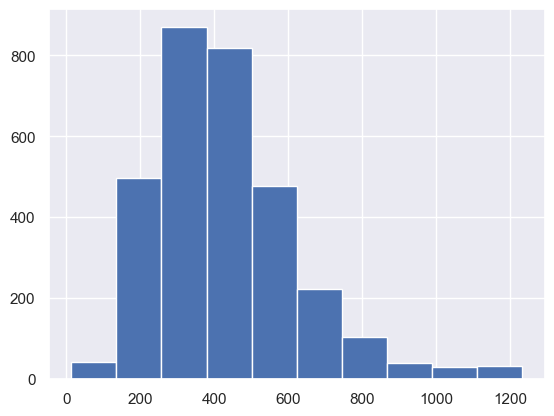

In [7]:
# Check the distribution of text lengths
train["length"] = train["text_index"].apply(lambda x: len(x))
train["length"].hist()
# Most seem to be in the 0-800 words range, max around 1200
# For now will keep the current length

In [8]:
# Determine max length (for paddings)
max_length = train["length"].max()

In [9]:
# Function to add 0s to the list until desired length has been reached
def add_paddings(my_list, desired_length=max_length):
    
    # Truncate the list ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).if it's too long
    if len(my_list) > desired_length:
        my_list = my_list[:desired_length]
        
    # Otherwise, add padded 0s until we've reached desired length
    else:
        while len(my_list) < desired_length:
            my_list.append(0)
            
    return my_list

# Apply the function to our training data
train["text_index"] = train["text_index"].apply(add_paddings)

In [10]:
# Finally - logistic regression with learned embeddings!
def build_embeddings_model(embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=len(full_word_list)+1,
      output_dim=embedding_dim,
      input_length=max_length)
  )

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=9,                     # output dim (for binary classification)
      activation='softmax'         # apply the sigmoid function!
  ))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='SGD',
                metrics=['accuracy'])

  return model

In [11]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

syntax
Epoch 1/5
 37/141 [======>.......................] - ETA: 0s - loss: 1.6541 - accuracy: 0.2716     

2022-11-27 11:35:09.472404: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


141/141 [==============================] - 0s 2ms/step - loss: 1.2147 - accuracy: 0.2998 - val_loss: 1.0027 - val_accuracy: 0.3035
Epoch 2/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0415 - accuracy: 0.2881 - val_loss: 0.9941 - val_accuracy: 0.3227
Epoch 3/5
141/141 [==============================] - 0s 2ms/step - loss: 1.0314 - accuracy: 0.2924 - val_loss: 0.9975 - val_accuracy: 0.3035
Epoch 4/5
141/141 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.2945 - val_loss: 1.0575 - val_accuracy: 0.3259
Epoch 5/5
141/141 [==============================] - 0s 3ms/step - loss: 1.0235 - accuracy: 0.2931 - val_loss: 0.9781 - val_accuracy: 0.3227


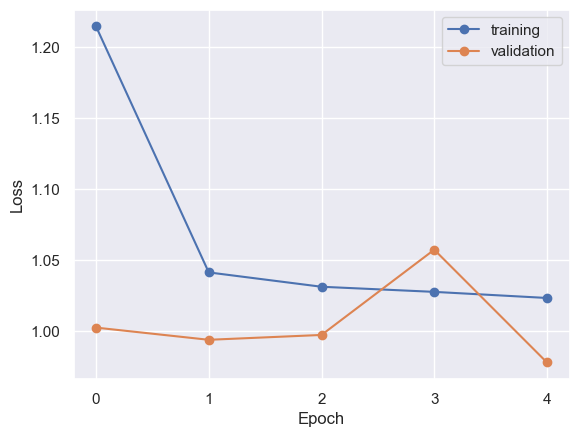

vocabulary
Epoch 1/5
141/141 [==============================] - 0s 2ms/step - loss: 1.1262 - accuracy: 0.3751 - val_loss: 0.9199 - val_accuracy: 0.3994
Epoch 2/5
141/141 [==============================] - 0s 1ms/step - loss: 0.9521 - accuracy: 0.3794 - val_loss: 0.9026 - val_accuracy: 0.3994
Epoch 3/5
141/141 [==============================] - 0s 2ms/step - loss: 0.9425 - accuracy: 0.3790 - val_loss: 0.9064 - val_accuracy: 0.3994
Epoch 4/5
141/141 [==============================] - 0s 1ms/step - loss: 0.9371 - accuracy: 0.3776 - val_loss: 0.9213 - val_accuracy: 0.3994
Epoch 5/5
141/141 [==============================] - 0s 1ms/step - loss: 0.9349 - accuracy: 0.3815 - val_loss: 0.9147 - val_accuracy: 0.4058


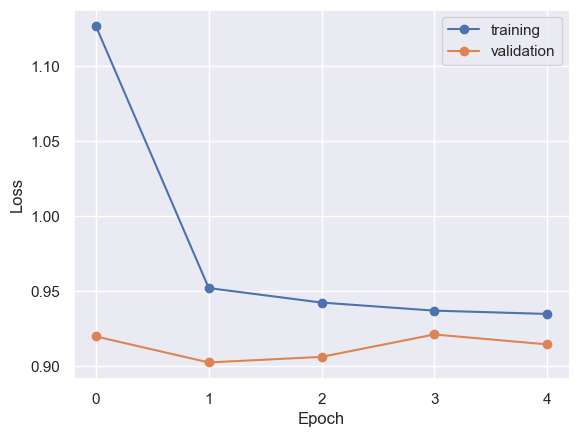

cohesion
Epoch 1/5
141/141 [==============================] - 0s 2ms/step - loss: 1.2538 - accuracy: 0.2632 - val_loss: 1.0001 - val_accuracy: 0.2460
Epoch 2/5
141/141 [==============================] - 0s 2ms/step - loss: 1.0731 - accuracy: 0.2622 - val_loss: 1.0001 - val_accuracy: 0.2332
Epoch 3/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0645 - accuracy: 0.2632 - val_loss: 1.0093 - val_accuracy: 0.2748
Epoch 4/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0592 - accuracy: 0.2632 - val_loss: 1.0238 - val_accuracy: 0.2748
Epoch 5/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0583 - accuracy: 0.2636 - val_loss: 0.9961 - val_accuracy: 0.2620


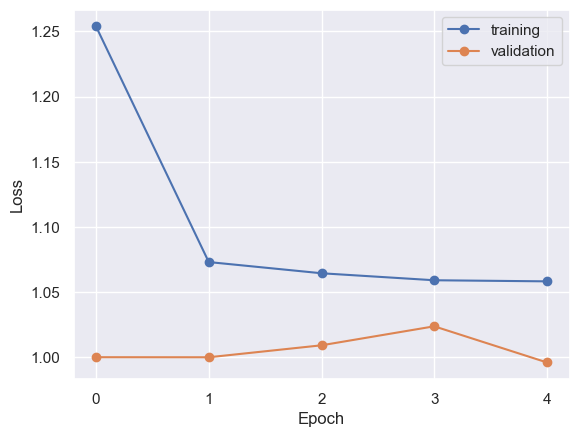

phraseology
Epoch 1/5
141/141 [==============================] - 0s 2ms/step - loss: 1.2209 - accuracy: 0.2782 - val_loss: 1.0875 - val_accuracy: 0.2939
Epoch 2/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0512 - accuracy: 0.2821 - val_loss: 1.0507 - val_accuracy: 0.2907
Epoch 3/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0380 - accuracy: 0.2838 - val_loss: 1.0455 - val_accuracy: 0.2620
Epoch 4/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0301 - accuracy: 0.2810 - val_loss: 1.0498 - val_accuracy: 0.2843
Epoch 5/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0305 - accuracy: 0.2860 - val_loss: 1.0447 - val_accuracy: 0.2843


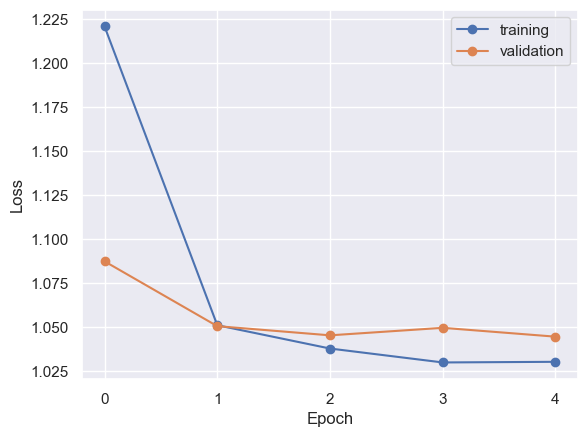

grammar
Epoch 1/5
141/141 [==============================] - 0s 2ms/step - loss: 1.2760 - accuracy: 0.2384 - val_loss: 1.0104 - val_accuracy: 0.2204
Epoch 2/5
141/141 [==============================] - 0s 1ms/step - loss: 1.1090 - accuracy: 0.2451 - val_loss: 0.9936 - val_accuracy: 0.2141
Epoch 3/5
141/141 [==============================] - 0s 1ms/step - loss: 1.1027 - accuracy: 0.2369 - val_loss: 1.0107 - val_accuracy: 0.2204
Epoch 4/5
141/141 [==============================] - 0s 2ms/step - loss: 1.0985 - accuracy: 0.2401 - val_loss: 0.9872 - val_accuracy: 0.2268
Epoch 5/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0934 - accuracy: 0.2387 - val_loss: 1.0172 - val_accuracy: 0.2204


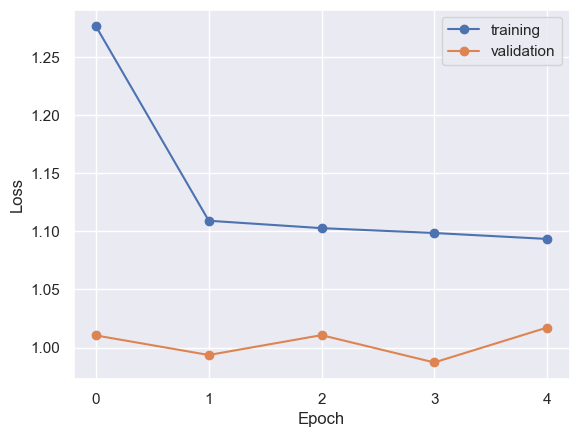

conventions
Epoch 1/5
141/141 [==============================] - 0s 2ms/step - loss: 1.2478 - accuracy: 0.2796 - val_loss: 1.0171 - val_accuracy: 0.2875
Epoch 2/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0781 - accuracy: 0.2838 - val_loss: 1.0179 - val_accuracy: 0.2875
Epoch 3/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0719 - accuracy: 0.2792 - val_loss: 1.0332 - val_accuracy: 0.2907
Epoch 4/5
141/141 [==============================] - 0s 1ms/step - loss: 1.0683 - accuracy: 0.2757 - val_loss: 1.0111 - val_accuracy: 0.2939
Epoch 5/5
141/141 [==============================] - 0s 2ms/step - loss: 1.0606 - accuracy: 0.2810 - val_loss: 1.0055 - val_accuracy: 0.2875


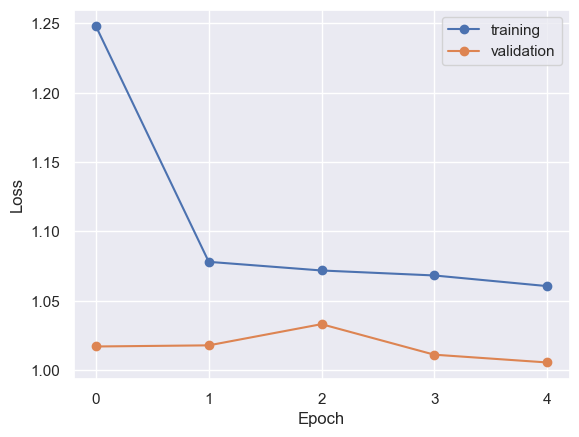

In [12]:
x_train = np.array([x for x in train["text_index"]])

for outcome in ["syntax", "vocabulary", "cohesion", "phraseology", "grammar", "conventions"]:
    print(outcome)
    y = np.asarray(train[outcome]).astype(np.float32)
    
    model = build_embeddings_model(embedding_dim=5)
    history = model.fit(
      x = x_train,  # our sparse padded training data
      y = y,          # corresponding binary labels
      epochs=5,             # number of passes through the training data
      batch_size=20,        # mini-batch size
      validation_split=0.1, # use a fraction of the examples for validation
      verbose=1             # display some progress output during training
            )

    history = pd.DataFrame(history.history)
    plot_history(history)

syntax
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1827 - accuracy: 0.1449 - val_loss: 2.1472 - val_accuracy: 0.2843
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 2.0625 - accuracy: 0.3023 - val_loss: 1.7872 - val_accuracy: 0.3259
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 1.3944 - accuracy: 0.3101 - val_loss: 1.1486 - val_accuracy: 0.3259
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1085 - accuracy: 0.3112 - val_loss: 1.1131 - val_accuracy: 0.3259
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 1.0642 - accuracy: 0.3098 - val_loss: 1.0341 - val_accuracy: 0.3227


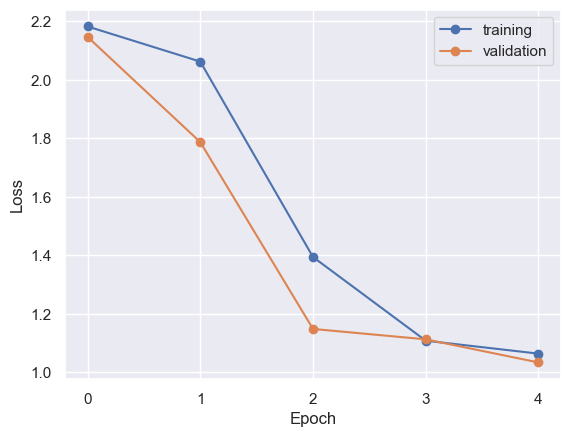

vocabulary
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1786 - accuracy: 0.2121 - val_loss: 2.1367 - val_accuracy: 0.3994
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 2.0415 - accuracy: 0.3812 - val_loss: 1.6838 - val_accuracy: 0.3994
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 1.3223 - accuracy: 0.3822 - val_loss: 1.0859 - val_accuracy: 0.3994
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 1.0479 - accuracy: 0.3819 - val_loss: 0.9878 - val_accuracy: 0.3994
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 0.9860 - accuracy: 0.3819 - val_loss: 0.9461 - val_accuracy: 0.3994


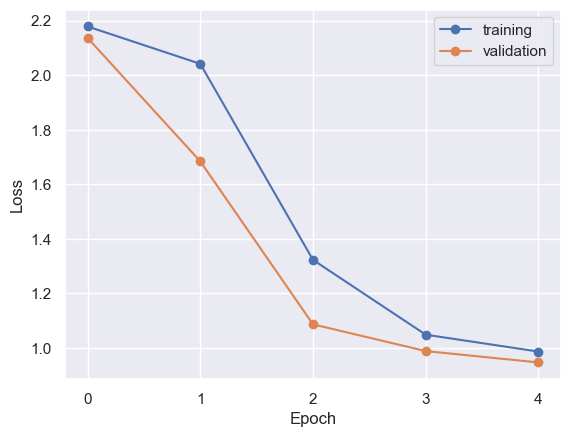

cohesion
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1841 - accuracy: 0.1300 - val_loss: 2.1475 - val_accuracy: 0.2684
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 2.0813 - accuracy: 0.2679 - val_loss: 1.8509 - val_accuracy: 0.2716
Epoch 3/5
15/15 [==============================] - 0s 12ms/step - loss: 1.4849 - accuracy: 0.2767 - val_loss: 1.1907 - val_accuracy: 0.2748
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1600 - accuracy: 0.2767 - val_loss: 1.0942 - val_accuracy: 0.2748
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1043 - accuracy: 0.2760 - val_loss: 1.0432 - val_accuracy: 0.2780


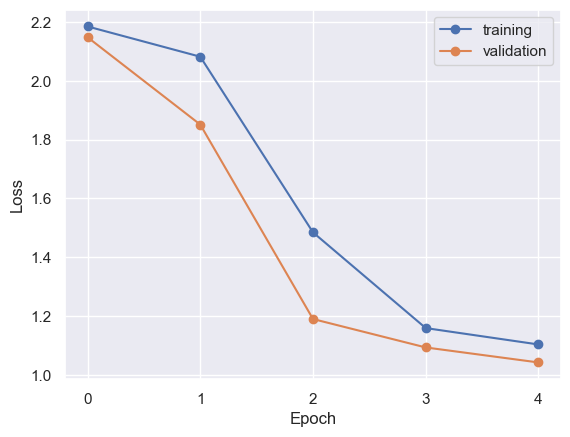

phraseology
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1837 - accuracy: 0.1385 - val_loss: 2.1511 - val_accuracy: 0.2684
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 2.0757 - accuracy: 0.2906 - val_loss: 1.8493 - val_accuracy: 0.2907
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 1.4540 - accuracy: 0.2959 - val_loss: 1.2182 - val_accuracy: 0.2939
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1276 - accuracy: 0.2956 - val_loss: 1.1258 - val_accuracy: 0.2939
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 1.0729 - accuracy: 0.2973 - val_loss: 1.0988 - val_accuracy: 0.2907


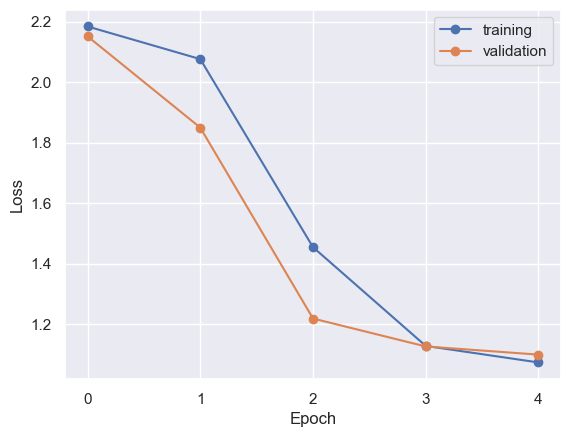

grammar
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1847 - accuracy: 0.1226 - val_loss: 2.1447 - val_accuracy: 0.2077
Epoch 2/5
15/15 [==============================] - 0s 9ms/step - loss: 2.0654 - accuracy: 0.2465 - val_loss: 1.7720 - val_accuracy: 0.2173
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 1.4387 - accuracy: 0.2568 - val_loss: 1.1197 - val_accuracy: 0.2204
Epoch 4/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1604 - accuracy: 0.2583 - val_loss: 1.0327 - val_accuracy: 0.2141
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 1.1220 - accuracy: 0.2487 - val_loss: 1.0283 - val_accuracy: 0.2300


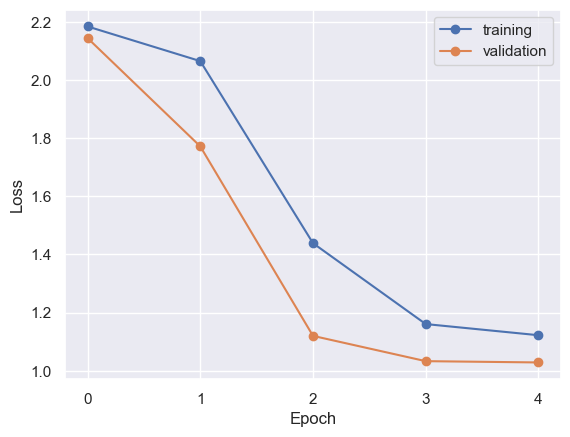

conventions
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 2.1835 - accuracy: 0.1336 - val_loss: 2.1455 - val_accuracy: 0.2684
Epoch 2/5
15/15 [==============================] - 0s 8ms/step - loss: 2.0668 - accuracy: 0.2853 - val_loss: 1.7943 - val_accuracy: 0.2875
Epoch 3/5
15/15 [==============================] - 0s 9ms/step - loss: 1.4351 - accuracy: 0.2959 - val_loss: 1.1734 - val_accuracy: 0.2907
Epoch 4/5
15/15 [==============================] - 0s 8ms/step - loss: 1.1457 - accuracy: 0.2959 - val_loss: 1.0774 - val_accuracy: 0.2907
Epoch 5/5
15/15 [==============================] - 0s 9ms/step - loss: 1.0962 - accuracy: 0.2966 - val_loss: 1.0459 - val_accuracy: 0.2907


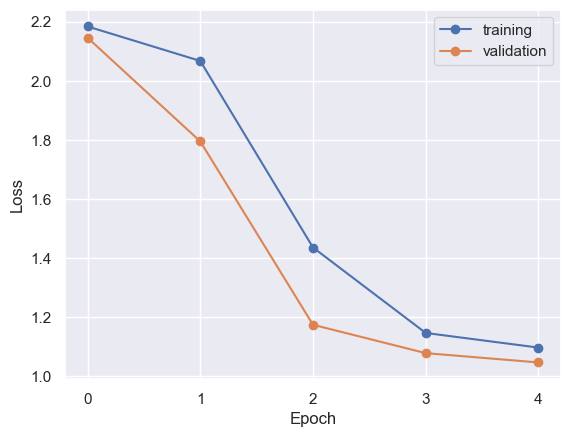

In [13]:
x_train = np.array([x for x in train["text_index"]])

for outcome in ["syntax", "vocabulary", "cohesion", "phraseology", "grammar", "conventions"]:
    print(outcome)
    y = np.asarray(train[outcome]).astype(np.float32)
    
    model = build_embeddings_model(embedding_dim=2)
    history = model.fit(
      x = x_train,  # our sparse padded training data
      y = y,          # corresponding binary labels
      epochs=5,             # number of passes through the training data
      batch_size=200,        # mini-batch size
      validation_split=0.1, # use a fraction of the examples for validation
      verbose=1             # display some progress output during training
            )

    history = pd.DataFrame(history.history)
    plot_history(history)

In [30]:
# Finally - logistic regression with learned embeddings!
def build_embeddings_w_cnn_model(embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=len(full_word_list)+1,
      output_dim=embedding_dim,
      input_length=max_length)
  )

  ### first convolution
  model.add(tf.keras.layers.Conv1D(
      filters = 100,
      kernel_size = 10,
      padding = "same",
      activation = "relu"
      ))
    
  # add Dropout for regularization
  model.add(tf.keras.layers.Dropout(0.1))

  # add maxpooling
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
  ### second convolution
  model.add(tf.keras.layers.Conv1D(
      filters = 50,
      kernel_size = 10,
      padding = "same",
      activation = "relu"
      ))
    
  # add Dropout for regularization
  model.add(tf.keras.layers.Dropout(0.1))

  # add maxpooling
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

  # Flatten
  model.add(tf.keras.layers.Flatten())
    
  # Output layer
  model.add(tf.keras.layers.Dense(
      units=9,                     # output dim (for binary classification)
      activation='softmax'         # apply the sigmoid function!
  ))

  model.compile(loss='sparse_categorical_crossentropy', 
                optimizer='SGD',
                metrics=['accuracy'])

  return model

syntax
Epoch 1/5
15/15 [==============================] - 4s 283ms/step - loss: 2.1073 - accuracy: 0.2956 - val_loss: 1.8318 - val_accuracy: 0.3259
Epoch 2/5
15/15 [==============================] - 4s 283ms/step - loss: 1.3331 - accuracy: 0.3101 - val_loss: 1.1341 - val_accuracy: 0.3259
Epoch 3/5
15/15 [==============================] - 4s 282ms/step - loss: 1.0720 - accuracy: 0.3101 - val_loss: 1.0836 - val_accuracy: 0.3259
Epoch 4/5
15/15 [==============================] - 4s 286ms/step - loss: 1.0531 - accuracy: 0.3098 - val_loss: 1.1230 - val_accuracy: 0.3259
Epoch 5/5
15/15 [==============================] - 4s 282ms/step - loss: 1.0548 - accuracy: 0.3101 - val_loss: 1.0372 - val_accuracy: 0.3259


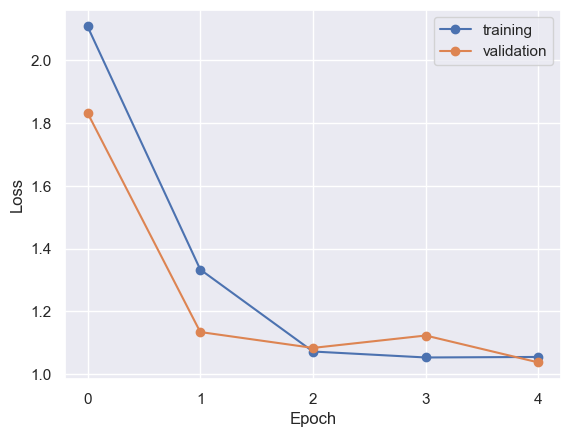

vocabulary
Epoch 1/5
15/15 [==============================] - 4s 286ms/step - loss: 2.0873 - accuracy: 0.3609 - val_loss: 1.6901 - val_accuracy: 0.3994
Epoch 2/5
15/15 [==============================] - 4s 282ms/step - loss: 1.2294 - accuracy: 0.3822 - val_loss: 1.0584 - val_accuracy: 0.3994
Epoch 3/5
15/15 [==============================] - 4s 281ms/step - loss: 1.0075 - accuracy: 0.3822 - val_loss: 0.9795 - val_accuracy: 0.3994
Epoch 4/5
15/15 [==============================] - 4s 282ms/step - loss: 0.9835 - accuracy: 0.3822 - val_loss: 0.9648 - val_accuracy: 0.3994
Epoch 5/5
15/15 [==============================] - 4s 283ms/step - loss: 0.9791 - accuracy: 0.3822 - val_loss: 0.9669 - val_accuracy: 0.3994


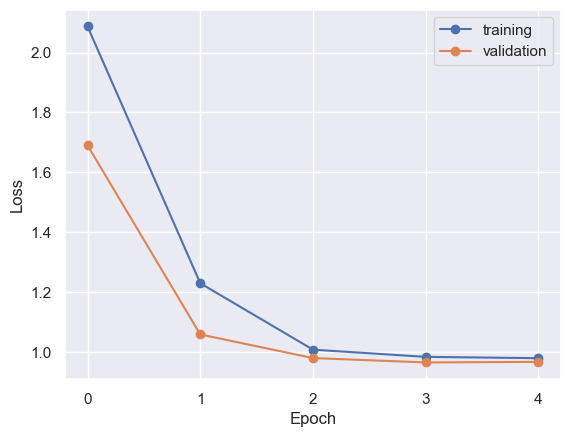

cohesion
Epoch 1/5
15/15 [==============================] - 4s 284ms/step - loss: 2.1178 - accuracy: 0.2615 - val_loss: 1.8746 - val_accuracy: 0.2748
Epoch 2/5
15/15 [==============================] - 4s 294ms/step - loss: 1.4108 - accuracy: 0.2771 - val_loss: 1.1762 - val_accuracy: 0.2748
Epoch 3/5
15/15 [==============================] - 4s 286ms/step - loss: 1.1223 - accuracy: 0.2771 - val_loss: 1.1005 - val_accuracy: 0.2748
Epoch 4/5
15/15 [==============================] - 4s 286ms/step - loss: 1.1016 - accuracy: 0.2771 - val_loss: 1.0929 - val_accuracy: 0.2748
Epoch 5/5
15/15 [==============================] - 4s 287ms/step - loss: 1.0991 - accuracy: 0.2771 - val_loss: 1.0774 - val_accuracy: 0.2748


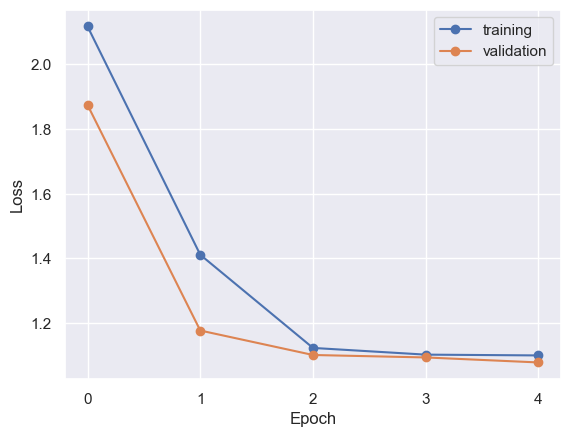

phraseology
Epoch 1/5
15/15 [==============================] - 5s 287ms/step - loss: 2.1133 - accuracy: 0.2813 - val_loss: 1.8632 - val_accuracy: 0.2939
Epoch 2/5
15/15 [==============================] - 4s 284ms/step - loss: 1.3735 - accuracy: 0.2959 - val_loss: 1.1921 - val_accuracy: 0.2939
Epoch 3/5
15/15 [==============================] - 4s 290ms/step - loss: 1.0925 - accuracy: 0.2959 - val_loss: 1.1164 - val_accuracy: 0.2939
Epoch 4/5
15/15 [==============================] - 4s 282ms/step - loss: 1.0663 - accuracy: 0.2959 - val_loss: 1.1060 - val_accuracy: 0.2939
Epoch 5/5
15/15 [==============================] - 4s 286ms/step - loss: 1.0650 - accuracy: 0.2959 - val_loss: 1.0991 - val_accuracy: 0.2939


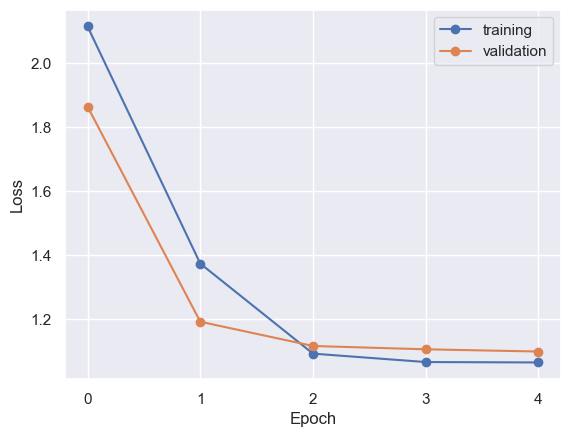

grammar
Epoch 1/5
15/15 [==============================] - 4s 282ms/step - loss: 2.1169 - accuracy: 0.2341 - val_loss: 1.8555 - val_accuracy: 0.2204
Epoch 2/5
15/15 [==============================] - 4s 282ms/step - loss: 1.4033 - accuracy: 0.2583 - val_loss: 1.1103 - val_accuracy: 0.2204
Epoch 3/5
15/15 [==============================] - 4s 285ms/step - loss: 1.1259 - accuracy: 0.2583 - val_loss: 1.0484 - val_accuracy: 0.2204
Epoch 4/5
15/15 [==============================] - 4s 283ms/step - loss: 1.1041 - accuracy: 0.2561 - val_loss: 1.0178 - val_accuracy: 0.2204
Epoch 5/5
15/15 [==============================] - 4s 282ms/step - loss: 1.1009 - accuracy: 0.2583 - val_loss: 1.0561 - val_accuracy: 0.1725


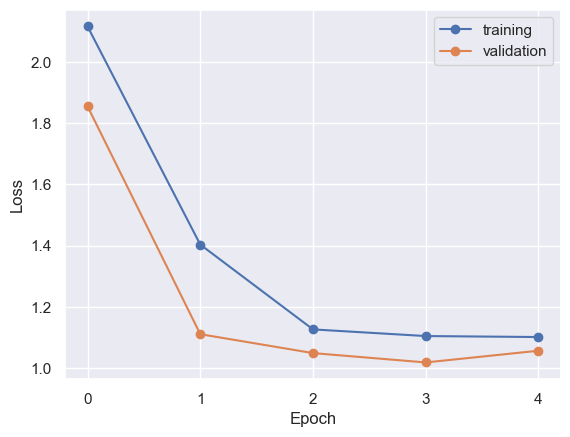

conventions
Epoch 1/5
15/15 [==============================] - 4s 284ms/step - loss: 2.1142 - accuracy: 0.2753 - val_loss: 1.8500 - val_accuracy: 0.2907
Epoch 2/5
15/15 [==============================] - 4s 280ms/step - loss: 1.3797 - accuracy: 0.2959 - val_loss: 1.1615 - val_accuracy: 0.2907
Epoch 3/5
15/15 [==============================] - 4s 281ms/step - loss: 1.1035 - accuracy: 0.2959 - val_loss: 1.1045 - val_accuracy: 0.2907
Epoch 4/5
15/15 [==============================] - 4s 279ms/step - loss: 1.0837 - accuracy: 0.2959 - val_loss: 1.0728 - val_accuracy: 0.2907
Epoch 5/5
15/15 [==============================] - 4s 280ms/step - loss: 1.0791 - accuracy: 0.2959 - val_loss: 1.0624 - val_accuracy: 0.2907


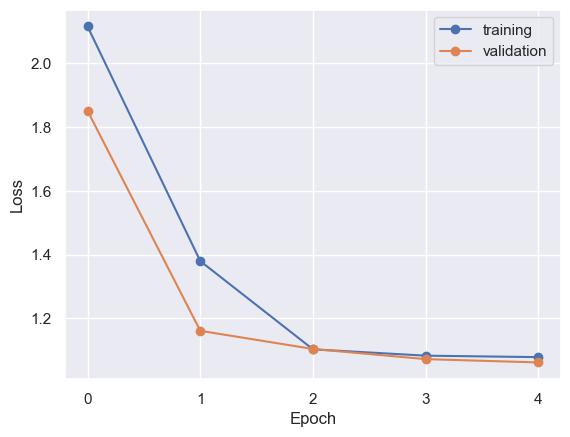

In [31]:
for outcome in ["syntax", "vocabulary", "cohesion", "phraseology", "grammar", "conventions"]:
    print(outcome)
    y = np.asarray(train[outcome]).astype(np.float32)
    
    model = build_embeddings_w_cnn_model(embedding_dim=2)
    history = model.fit(
      x = x_train,  # our sparse padded training data
      y = y,          # corresponding binary labels
      epochs=5,             # number of passes through the training data
      batch_size=200,        # mini-batch size
      validation_split=0.1, # use a fraction of the examples for validation
      verbose=1             # display some progress output during training
            )

    history = pd.DataFrame(history.history)
    plot_history(history)